Importar librerias necesarias 

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

Configuramos el estilo que usará matplotlib para observar mejor las graficas. Ademas, configuramos la paleta de colores que usaremos

In [52]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Cargamos los datos e imprimimos la forma del df

In [53]:
def Carga():
    train = pd.read_csv("train.csv")
    print(f"Dataset shape: {train.shape}")
    return train

Esta funcion verifica si hay id duplicado (lo que supondria la eliminacion de alguna fila repetida) y posteriormente elimina la columna id porque no aporta informacion predictiva. Luego se cuentan los valores nulos por cada columna y se ordenan de mayor a menor para graficarlos (si los hay). Despues procedemos a observar el balanceo de clases ordenada por categorias (el 'peso' que puede sesgar el modelo hacia la clase mayoritaria). Por ultimo miramos que columnas son categoricas, las agrupamos y hacemos un analisis de cardinalidad (cuando hay demasiados valores diferentes entonces hay demasiadas columnas cuando se usa one-hot)

In [54]:
def analisis_exploratorio(train):
    print("ANÁLISIS EXPLORATORIO")
    
    # Verificar ID duplicados
    print(f"IDs duplicados: {train['ID'].duplicated().any()}")
    # Eliminar ID 
    train = train.drop(columns=['ID'])
    #Grafica de valores nulos
    plt.figure(figsize=(12, 6))
    missing_data = train.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    if len(missing_data) > 0:
        plt.subplot(1, 2, 1)
        missing_data.plot(kind='bar', color='coral')
        plt.title('Valores Nulos por Columna')
        plt.xticks(rotation=45)
        plt.tight_layout()
    else:
        print("No hay valores nulos en el dataset")
    #Distribucion de la variable target
    plt.subplot(1, 2, 2)
    train['RENDIMIENTO_GLOBAL'].value_counts().sort_index().plot(kind='bar', color='lightblue')
    plt.title('Distribución de RENDIMIENTO_GLOBAL (Original)')
    plt.xlabel('Categorías de Rendimiento')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
    #Informacion de columnas categoricas
    categorical_cols = train.select_dtypes(include=['object']).columns
    print(f"\nColumnas categóricas: {len(categorical_cols)}")
    #Analizar cardinalidad de variables categoricas
    print("\nANÁLISIS DE CARDINALIDAD")
    
    for col in categorical_cols:
        n_unique = train[col].nunique()
        print(f"{col}: {n_unique} categorías únicas")
        if n_unique > 50:
            print(f"ALTA CARDINALIDAD - Considerar encoding alternativo")
    #Graficas de las principales variables categoricas
    plot_top_variables_categoricas(train, categorical_cols)
    
    return train

Seleccionamos columnas con 15 o menos categorias unicas (mas de eso es imposible de ver bien), luego graficamos para hacer un scanning rapido antes de transformar las variables categoricas. Esta funcion se ejecuta en la primer funcion.

In [55]:
def plot_top_variables_categoricas(train, categorical_cols, top_n=5):
    #Seleccionar variables con cardinalidad moderada para visualizacion
    plotable_cols = [col for col in categorical_cols if train[col].nunique() <= 15]
    plotable_cols = plotable_cols[:top_n]
    if plotable_cols:
        n_cols = min(2, len(plotable_cols))
        n_rows = (len(plotable_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_rows > 1:
            axes = axes.flatten()
        else:
            axes = [axes] if n_cols == 1 else axes
        for i, col in enumerate(plotable_cols):
            if i < len(axes):
                value_counts = train[col].value_counts().head(10)
                if len(value_counts) > 1:
                    axes[i].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
                    axes[i].set_title(f'Distribución de {col}\n({len(value_counts)} categorías)')
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False) 
        plt.tight_layout()
        plt.show()

Dataset shape: (692500, 21)
ANÁLISIS EXPLORATORIO
IDs duplicados: False


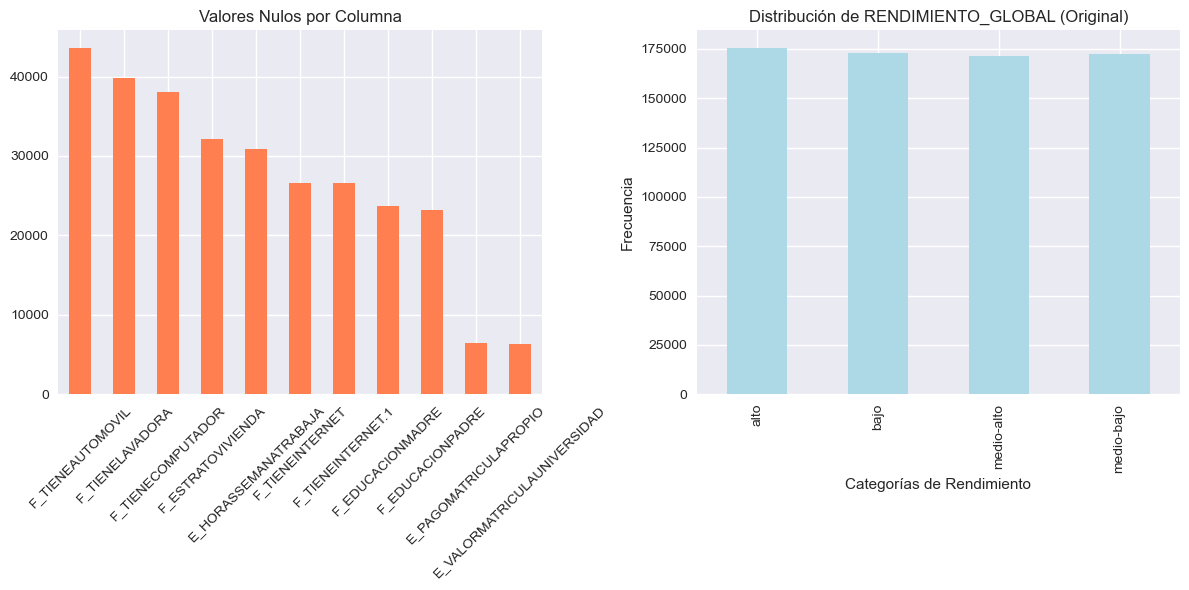


Columnas categóricas: 15

ANÁLISIS DE CARDINALIDAD
E_PRGM_ACADEMICO: 948 categorías únicas
ALTA CARDINALIDAD - Considerar encoding alternativo
E_PRGM_DEPARTAMENTO: 31 categorías únicas
E_VALORMATRICULAUNIVERSIDAD: 8 categorías únicas
E_HORASSEMANATRABAJA: 5 categorías únicas
F_ESTRATOVIVIENDA: 7 categorías únicas
F_TIENEINTERNET: 2 categorías únicas
F_EDUCACIONPADRE: 12 categorías únicas
F_TIENELAVADORA: 2 categorías únicas
F_TIENEAUTOMOVIL: 2 categorías únicas
E_PRIVADO_LIBERTAD: 2 categorías únicas
E_PAGOMATRICULAPROPIO: 2 categorías únicas
F_TIENECOMPUTADOR: 2 categorías únicas
F_TIENEINTERNET.1: 2 categorías únicas
F_EDUCACIONMADRE: 12 categorías únicas
RENDIMIENTO_GLOBAL: 4 categorías únicas


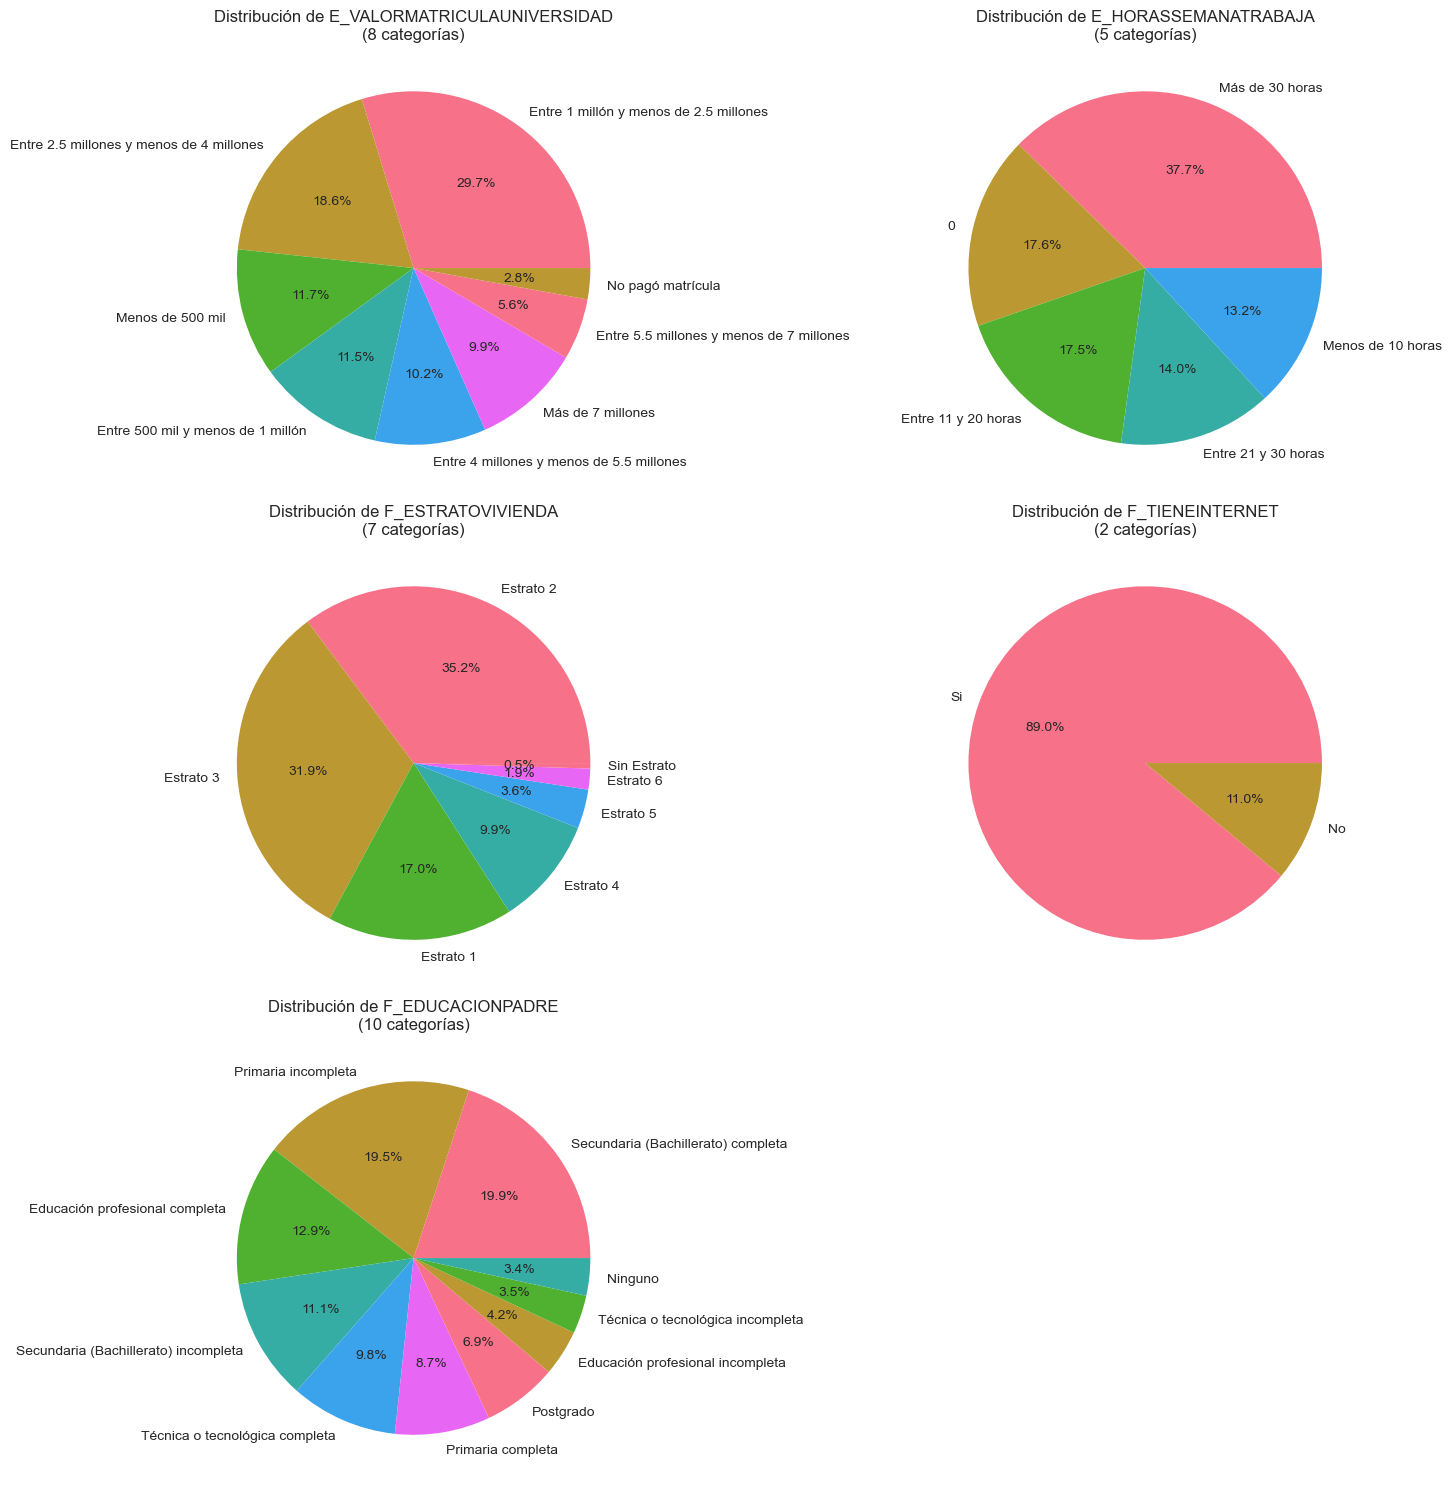

In [56]:
train = Carga()
train = analisis_exploratorio(train)

Simplemente cambiamos la variable target que originalmente es categorica por una numerica, donde se preserva un orden ordinal para que el modelo entienda la relacion

In [57]:
def preprocesamiento(train):
    print("PREPROCESAMIENTO TARGET")
    rendimiento_num = {
        'bajo': 1,
        'medio-bajo': 2,
        'medio-alto': 3,
        'alto': 4
    }
    #Grafica antes y después del mapeo
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    #Antes
    train['RENDIMIENTO_GLOBAL'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='lightblue')
    ax1.set_title('RENDIMIENTO_GLOBAL (Antes)')
    ax1.set_xlabel('Categorías')
    ax1.set_ylabel('Frecuencia')
    train['RENDIMIENTO_GLOBAL'] = train['RENDIMIENTO_GLOBAL'].map(rendimiento_num)
    # Despues
    train['RENDIMIENTO_GLOBAL'].value_counts().sort_index().plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('RENDIMIENTO_GLOBAL (Después)')
    ax2.set_xlabel('Valores Numéricos')
    ax2.set_ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
    print("Distribución del target después del mapeo:")
    print(train['RENDIMIENTO_GLOBAL'].value_counts().sort_index())
    return train

La traduccion de variables categoricas a ordinales

In [58]:
def mapeo_ordinal(column_name):
    mappings = {
        'E_VALORMATRICULAUNIVERSIDAD': {
            'Menos de 500 mil': 1,
            'Entre 500 mil y menos de 1 millón': 2,
            'Entre 1 millón y menos de 2.5 millones': 3,
            'Entre 2.5 millones y menos de 4 millones': 4,
            'Entre 4 millones y menos de 5.5 millones': 5,
            'Entre 5.5 millones y menos de 7 millones': 6,
            'Más de 7 millones': 7,
            'No pagó matrícula': 0,
            'Desconocido': -1
        },
        'E_HORASSEMANATRABAJA': {
            '0': 0,
            'Menos de 10 horas': 1,
            'Entre 11 y 20 horas': 2,
            'Entre 21 y 30 horas': 3,
            'Más de 30 horas': 4,
            'Desconocido': -1
        },
        'F_ESTRATOVIVIENDA': {
            'Desconocido': -1,
            'Sin Estrato': 0,
            'Estrato 1': 1,
            'Estrato 2': 2,
            'Estrato 3': 3,
            'Estrato 4': 4,
            'Estrato 5': 5,
            'Estrato 6': 6
        },
        'F_EDUCACIONPADRE': {
            'Desconocido': -1,
            'Ninguno': 0,
            'No sabe': -2,
            'No Aplica': -3,
            'Primaria incompleta': 1,
            'Primaria completa': 2,
            'Secundaria (Bachillerato) incompleta': 3,
            'Secundaria (Bachillerato) completa': 4,
            'Técnica o tecnológica incompleta': 5,
            'Técnica o tecnológica completa': 6,
            'Educación profesional incompleta': 7,
            'Educación profesional completa': 8,
            'Postgrado': 9
        },
        'F_EDUCACIONMADRE': {
            'Desconocido': -1,
            'Ninguno': 0,
            'No sabe': -2,
            'No Aplica': -3,
            'Primaria incompleta': 1,
            'Primaria completa': 2,
            'Secundaria (Bachillerato) incompleta': 3,
            'Secundaria (Bachillerato) completa': 4,
            'Técnica o tecnológica incompleta': 5,
            'Técnica o tecnológica completa': 6,
            'Educación profesional incompleta': 7,
            'Educación profesional completa': 8,
            'Postgrado': 9
        }
    }
    return mappings.get(column_name, {})

Cambiamos la variable categorica por su frecuencia de aparicion (de manera que no tengamos muchas dimensiones si usaramos one-hot). Luego agrupamos las categorias menos frecuentes en una nueva variable llamada 'Otros'

In [59]:
def Codificacion(X_train, X_test, high_card_cols, max_categories=20):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    for col in high_card_cols:
        if col in X_train.columns:
            #Usar frecuencia de cada categoria
            freq_encoding = X_train[col].value_counts().to_dict()
            X_train_encoded[col] = X_train[col].map(freq_encoding)
            X_test_encoded[col] = X_test[col].map(freq_encoding).fillna(-1)
            #Agrupar las menos frecuentes
            if X_train_encoded[col].nunique() > max_categories:
                value_counts = X_train[col].value_counts()
                top_categories = value_counts.head(max_categories-1).index
                X_train_encoded[col] = X_train[col].apply(
                    lambda x: x if x in top_categories else 'Otros'
                )
                X_test_encoded[col] = X_test[col].apply(
                    lambda x: x if x in top_categories else 'Otros'
                )
                freq_encoding = X_train_encoded[col].value_counts().to_dict()
                X_train_encoded[col] = X_train_encoded[col].map(freq_encoding)
                X_test_encoded[col] = X_test_encoded[col].map(freq_encoding).fillna(-1)
    return X_train_encoded, X_test_encoded

Mapeo de las columnas categoricas y de las columnas estilo binaria

In [60]:
def mapeo_col_ordinal(X, column_name):
    mapping = mapeo_ordinal(column_name)
    if mapping and column_name in X.columns:
        X[column_name] = X[column_name].map(mapping)
    return X

def mapeo_col_binario(X):
    binary_columns = [
        'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 
        'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET', 'F_TIENEINTERNET.1'
    ]
    binary_mapping = {
        'No': 0, 'N': 0, 'Si': 1, 'Sí': 1, 'S': 1, 'Desconocido': -1
    }
    for col in binary_columns:
        if col in X.columns:
            X[col] = X[col].fillna('Desconocido')
            X[col] = X[col].map(binary_mapping)
    return X

Hacemos copias para no dañar las originales, y con las funciones anteriormente creadas hacemos el mapeo de las columnas categoricas. Luego graficamos para validad visualmente las transformaciones (puedes ser un problema para el modelo el alto numero de carreras y posiblemente los muchos departamentos)

In [61]:
def preprocesamiento_m(X_train, X_test):
    print("PREPROCESAMIENTO MANUAL")
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    #Variables ordinales
    ordinal_columns = [
        'E_VALORMATRICULAUNIVERSIDAD', 
        'E_HORASSEMANATRABAJA',
        'F_ESTRATOVIVIENDA',
        'F_EDUCACIONPADRE', 
        'F_EDUCACIONMADRE'
    ]
    for col in ordinal_columns:
        if col in X_train_processed.columns:
            # Aplicar imputación y mapeo
            X_train_processed[col] = X_train_processed[col].fillna('Desconocido')
            X_test_processed[col] = X_test_processed[col].fillna('Desconocido')
            X_train_processed = mapeo_col_ordinal(X_train_processed, col)
            X_test_processed = mapeo_col_ordinal(X_test_processed, col)
    #Variables binarias
    X_train_processed = mapeo_col_binario(X_train_processed)
    X_test_processed = mapeo_col_binario(X_test_processed)
    #Variables de alta cardinalidad
    high_card_cols = ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO']
    X_train_processed, X_test_processed = Codificacion(
        X_train_processed, X_test_processed, high_card_cols
    )
    #Grafica distribucion de variables ordinales despues del preprocesamiento
    plot_ordinal_distributions(X_train_processed, ordinal_columns)
    #Grafica distribucion de variables binarias
    plot_binary_distributions(X_train_processed)
    return X_train_processed, X_test_processed

Validacion de mapeo, distribucion, valores atipicos en las ordinales

In [62]:
def plot_ordinal_distributions(X_train, ordinal_columns):
    available_columns = [col for col in ordinal_columns if col in X_train.columns]
    if available_columns:
        n_cols = min(3, len(available_columns))
        n_rows = (len(available_columns) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        for i, col in enumerate(available_columns):
            if i < len(axes):
                #Contar valores y ordenar por clave
                value_counts = X_train[col].value_counts().sort_index()
                axes[i].bar(value_counts.index, value_counts.values, color='skyblue', alpha=0.7)
                axes[i].set_title(f'Distribución de {col} (Procesada)')
                axes[i].set_xlabel('Valores')
                axes[i].set_ylabel('Frecuencia')
                axes[i].tick_params(axis='x', rotation=45)
        #Ocultar ejes vacios
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        plt.tight_layout()
        plt.show()

Validacion de mapeo, distribucion, valores atipicos en las binarias

In [63]:
def plot_binary_distributions(X_train):
    binary_columns = [
        'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 
        'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET', 'F_TIENEINTERNET.1'
    ]
    available_columns = [col for col in binary_columns if col in X_train.columns]
    if available_columns:
        n_cols = min(3, len(available_columns))
        n_rows = (len(available_columns) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        for i, col in enumerate(available_columns):
            if i < len(axes):
                value_counts = X_train[col].value_counts()
                labels = ['No (0)' if x == 0 else 'Sí (1)' if x == 1 else 'Desconocido (-1)' for x in value_counts.index]
                axes[i].pie(value_counts.values, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen', 'lightgray'])
                axes[i].set_title(f'Distribución de {col}')
        #Ocultar ejes vacios
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        plt.tight_layout()
        plt.show()

En nuestro caso esta funcion no es util pero lo puede ser si se añade en un futuro alguna otra variable ordinal o binaria. Como aqui ya esta todo preprocesado, esta funcion pasa todas las columnas tal cual como venian.

In [64]:
def create_optimized_pipeline():
    numeric_features = [] 
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='passthrough'
    )
    return preprocessor

Esta funcion es el corazon del flujo de preprocesado manual, ya que se encarga de coordinar todas las funciones que se han creado

In [65]:
def apply_complete_preprocessing(train):
    print("PREPROCESAMIENTO COMPLETO")
    #Separar features y target 
    X = train.drop('RENDIMIENTO_GLOBAL', axis=1)
    y = train['RENDIMIENTO_GLOBAL']
    #Dividir en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    # Grafica distribucion del target en train y test
    plot_train_test_distribution(y_train, y_test)
    #Preprocesamiento manual
    X_train_processed, X_test_processed = preprocesamiento_m(X_train, X_test)
    
    #Aplicar pipeline
    preprocessor = create_optimized_pipeline()
    X_train_final = preprocessor.fit_transform(X_train_processed)
    X_test_final = preprocessor.transform(X_test_processed)
    #Obtener nombres de columnas
    feature_names = list(X_train_processed.columns)
    #Convertir a DataFrames
    X_train_final = pd.DataFrame(X_train_final, columns=feature_names, index=X_train.index)
    X_test_final = pd.DataFrame(X_test_final, columns=feature_names, index=X_test.index)
    #Grafica matriz de correlacion después del preprocesamiento
    plot_correlation_matrix(X_train_final, y_train)
    #Información final del dataset procesado
    print(f"\n=== DATASET PROCESADO ===")
    print(f"Dimensiones finales: {X_train_final.shape}")
    print(f"Memoria aproximada: {X_train_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return X_train_final, X_test_final, y_train, y_test, preprocessor

En la primera funcion verificamos que la division en train/test mantuvo la misma distribucion gracias a la estratificacion, y en la segunda verificamos que variables estan mas relacionadas con el target despues de todo el preprocesamiento

In [66]:
def plot_train_test_distribution(y_train, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    y_train.value_counts().sort_index().plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
    ax1.set_title('Distribución de Target - Training Set')
    ax1.set_xlabel('RENDIMIENTO_GLOBAL')
    ax1.set_ylabel('Frecuencia')
    y_test.value_counts().sort_index().plot(kind='bar', ax=ax2, color='red', alpha=0.7)
    ax2.set_title('Distribución de Target - Test Set')
    ax2.set_xlabel('RENDIMIENTO_GLOBAL')
    ax2.set_ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(X_train_processed, y_train):
    correlation_data = X_train_processed.copy()
    correlation_data['RENDIMIENTO_GLOBAL'] = y_train
    plt.figure(figsize=(10, 6))
    numeric_columns = correlation_data.select_dtypes(include=[np.number]).columns
    if len(numeric_columns) > 1:
        #Calcular correlaciones con el target
        target_correlations = correlation_data[numeric_columns].corr()['RENDIMIENTO_GLOBAL'].drop('RENDIMIENTO_GLOBAL')
        target_correlations = target_correlations.sort_values(ascending=False)
        #Graficar top 15 correlaciones
        top_correlations = target_correlations.head(15)
        colors = ['red' if x < 0 else 'blue' for x in top_correlations.values]
        plt.barh(range(len(top_correlations)), top_correlations.values, color=colors)
        plt.yticks(range(len(top_correlations)), top_correlations.index)
        plt.xlabel('Correlación con RENDIMIENTO_GLOBAL')
        plt.title('Top 15 Variables con Mayor Correlación con el Target')
        plt.tight_layout()
        plt.show()
        print("\nTop 10 variables más correlacionadas con el target:")
        for i, (feature, corr) in enumerate(target_correlations.head(10).items(), 1):
            print(f"{i}. {feature}: {corr:.3f}")

In [67]:
def main():
    train = Carga()
    train = analisis_exploratorio(train)
    train = preprocesamiento(train)
    X_train, X_test, y_train, y_test, preprocessor = apply_complete_preprocessing(train)
    print("\n=== RESULTADO FINAL ===")
    print(f"X_train procesado: {X_train.shape}")
    print(f"X_test procesado: {X_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    #Mostrar primeras filas
    print("\nPrimeras 5 filas de X_train procesado:")
    print(X_train.head())
    #Informacion de tipos de datos
    print("\nTipos de datos en X_train:")
    print(X_train.dtypes.value_counts())
    # Verificar que no hay valores nulos
    print(f"\nValores nulos en X_train: {X_train.isnull().sum().sum()}")
    print(f"Valores nulos en X_test: {X_test.isnull().sum().sum()}")
    return X_train, X_test, y_train, y_test, preprocessor

Dataset shape: (692500, 21)
ANÁLISIS EXPLORATORIO
IDs duplicados: False


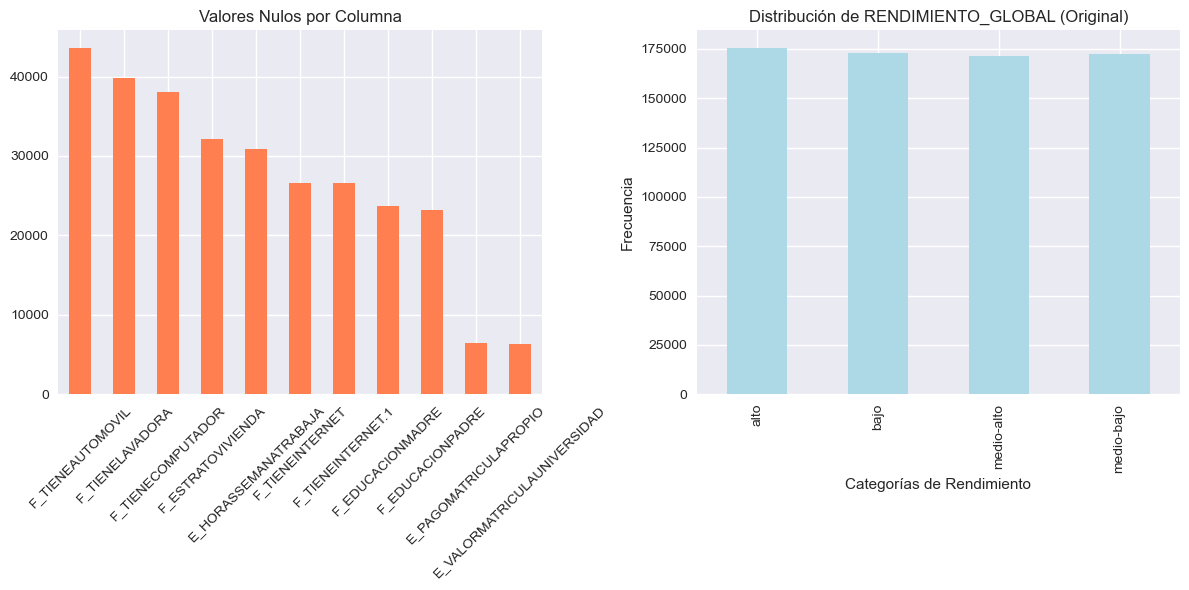


Columnas categóricas: 15

ANÁLISIS DE CARDINALIDAD
E_PRGM_ACADEMICO: 948 categorías únicas
ALTA CARDINALIDAD - Considerar encoding alternativo
E_PRGM_DEPARTAMENTO: 31 categorías únicas
E_VALORMATRICULAUNIVERSIDAD: 8 categorías únicas
E_HORASSEMANATRABAJA: 5 categorías únicas
F_ESTRATOVIVIENDA: 7 categorías únicas
F_TIENEINTERNET: 2 categorías únicas
F_EDUCACIONPADRE: 12 categorías únicas
F_TIENELAVADORA: 2 categorías únicas
F_TIENEAUTOMOVIL: 2 categorías únicas
E_PRIVADO_LIBERTAD: 2 categorías únicas
E_PAGOMATRICULAPROPIO: 2 categorías únicas
F_TIENECOMPUTADOR: 2 categorías únicas
F_TIENEINTERNET.1: 2 categorías únicas
F_EDUCACIONMADRE: 12 categorías únicas
RENDIMIENTO_GLOBAL: 4 categorías únicas


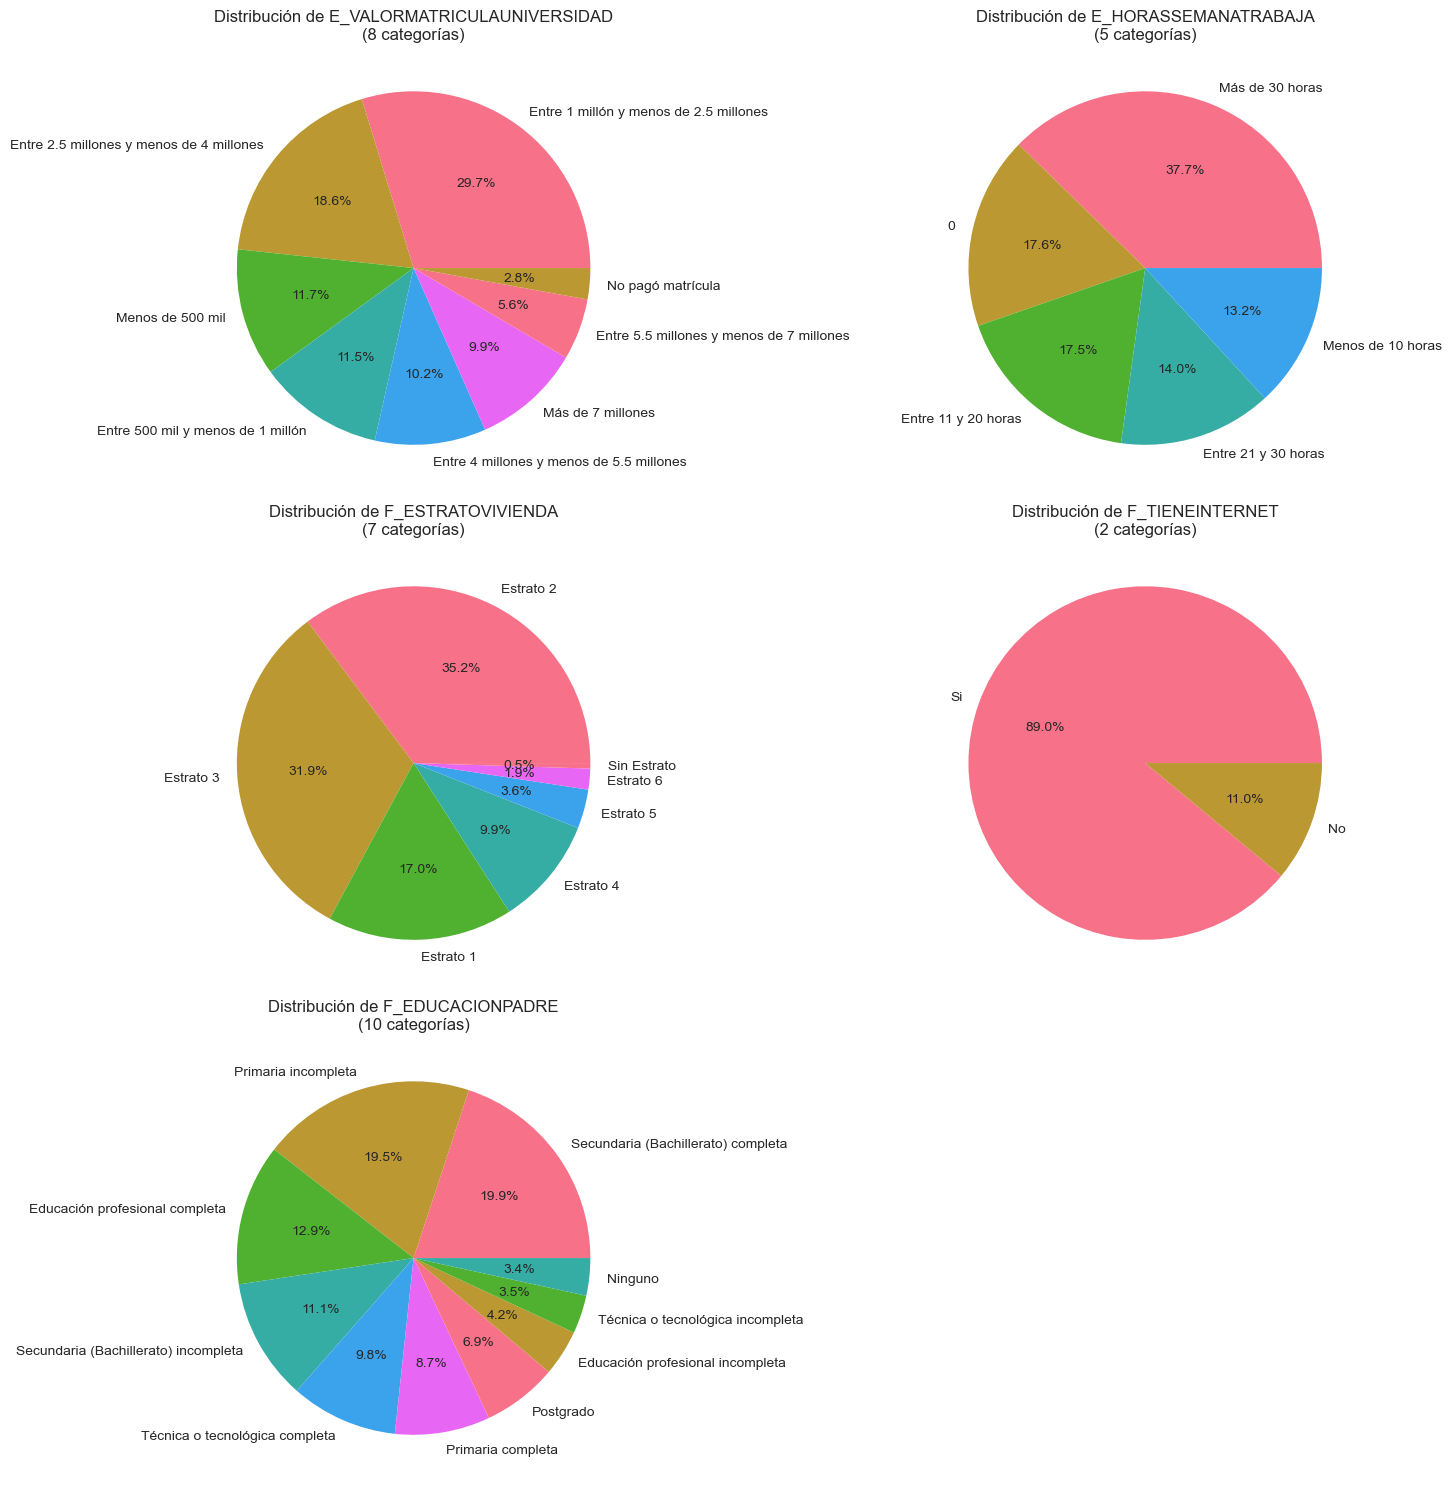

PREPROCESAMIENTO TARGET


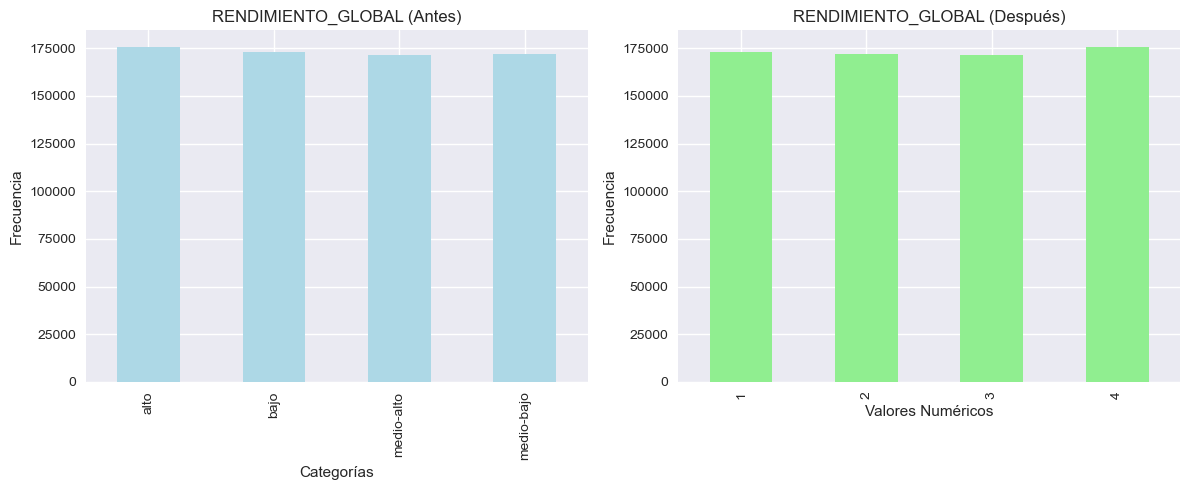

Distribución del target después del mapeo:
RENDIMIENTO_GLOBAL
1    172987
2    172275
3    171619
4    175619
Name: count, dtype: int64
PREPROCESAMIENTO COMPLETO
Training set: (554000, 19)
Test set: (138500, 19)


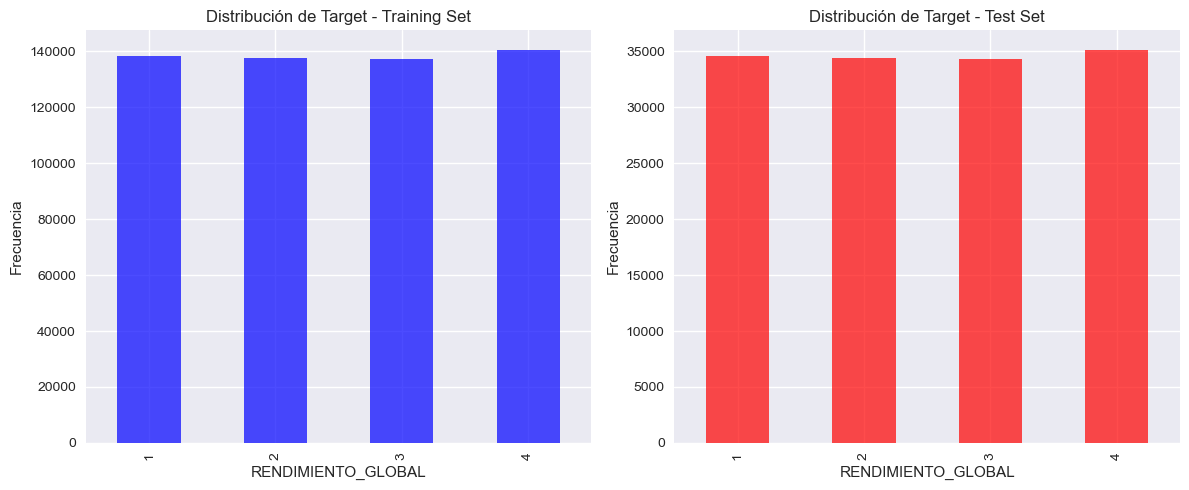

PREPROCESAMIENTO MANUAL


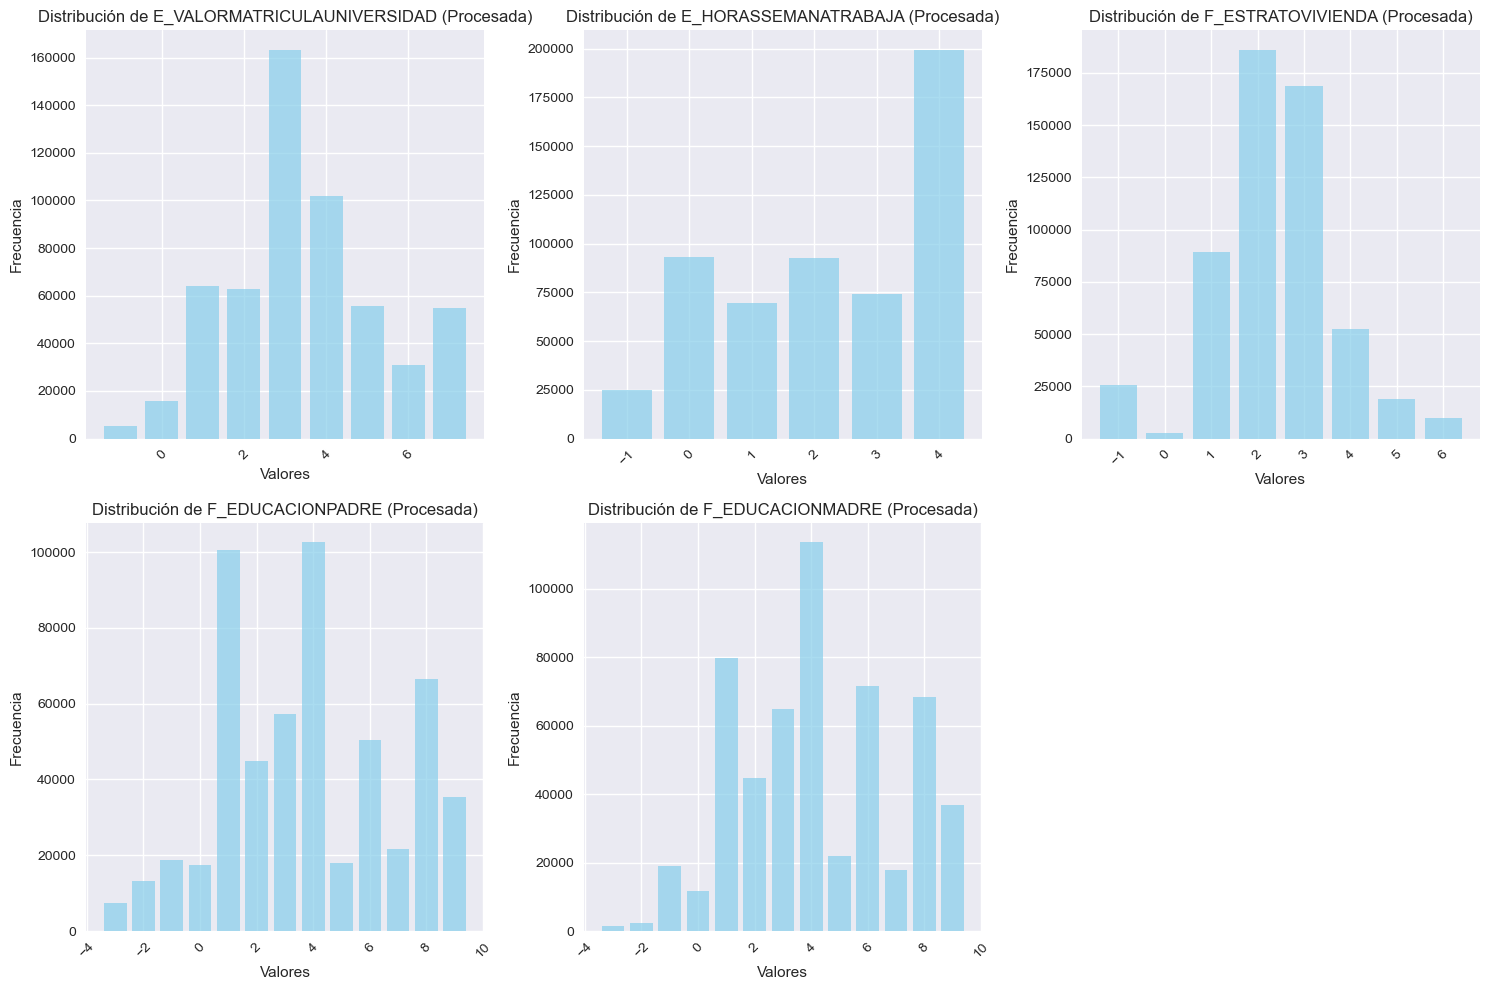

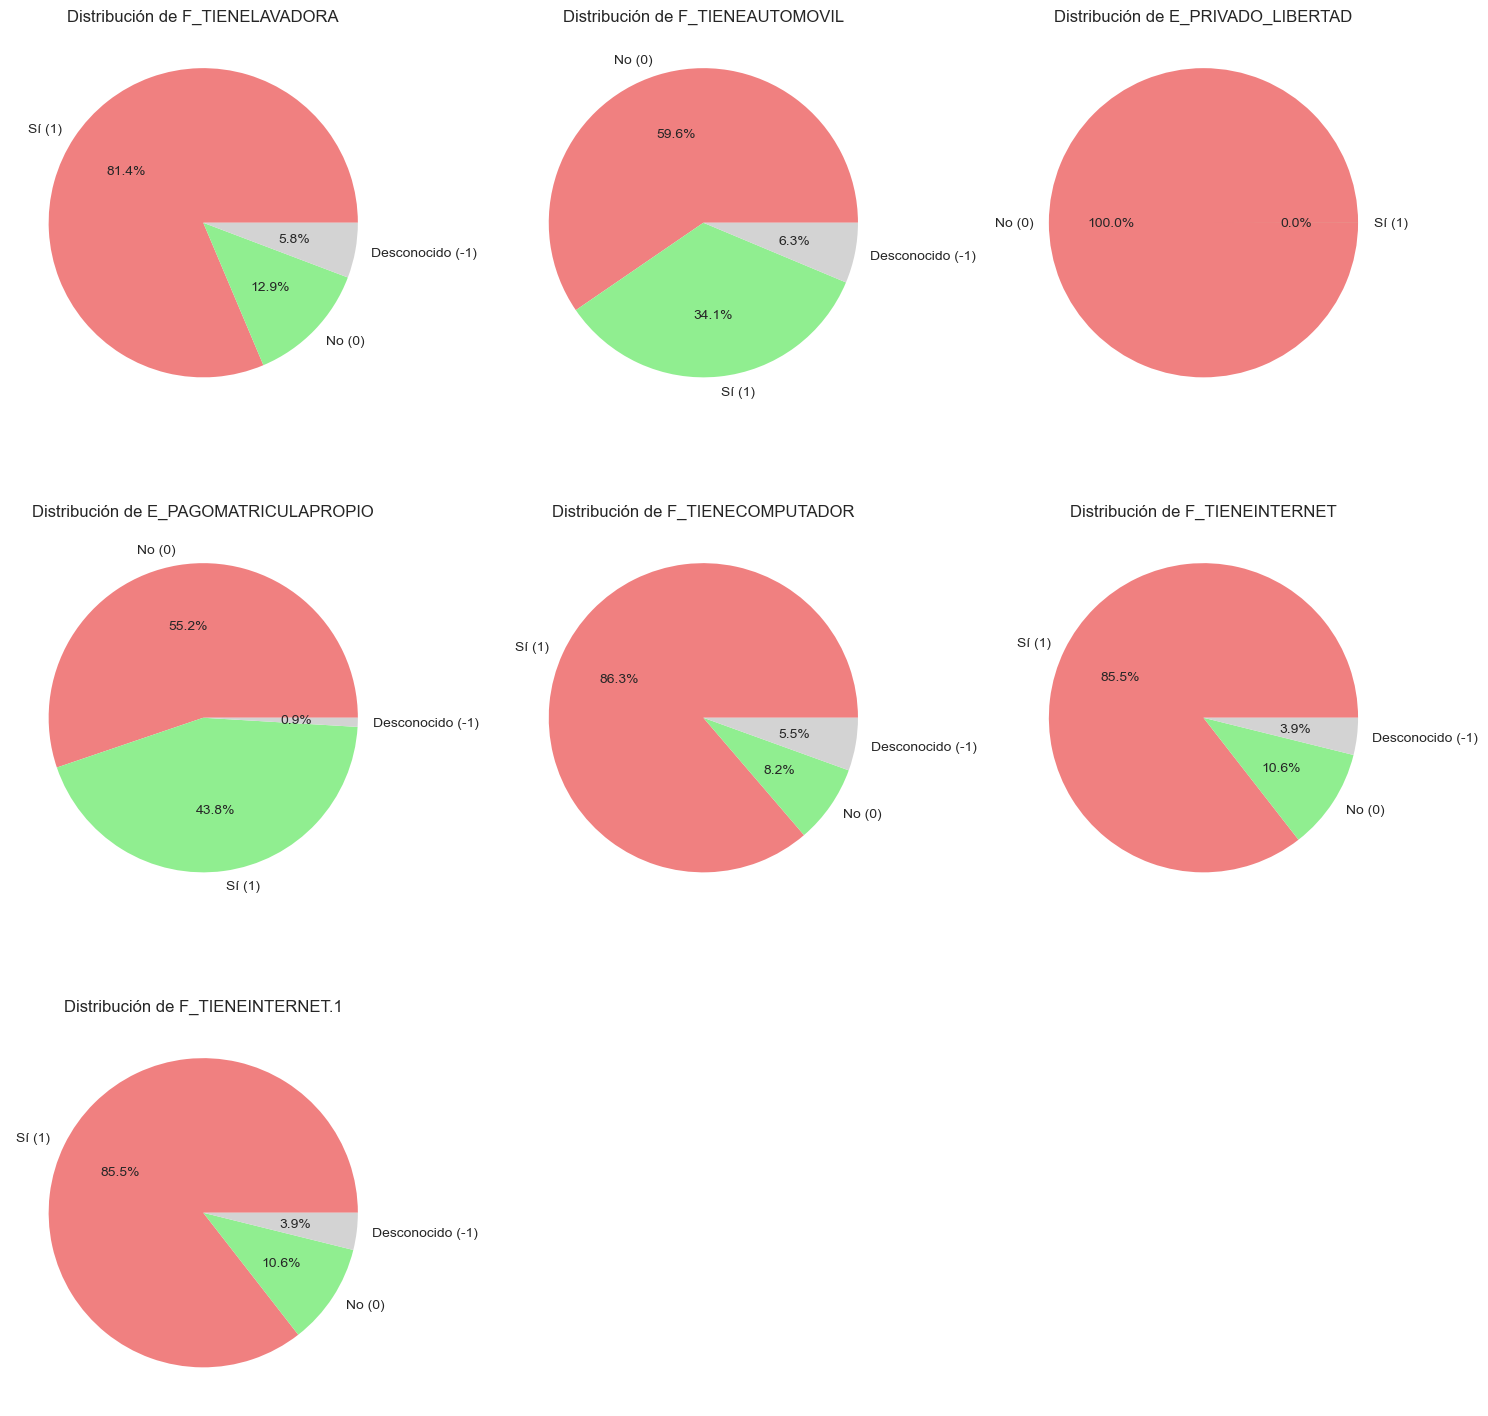

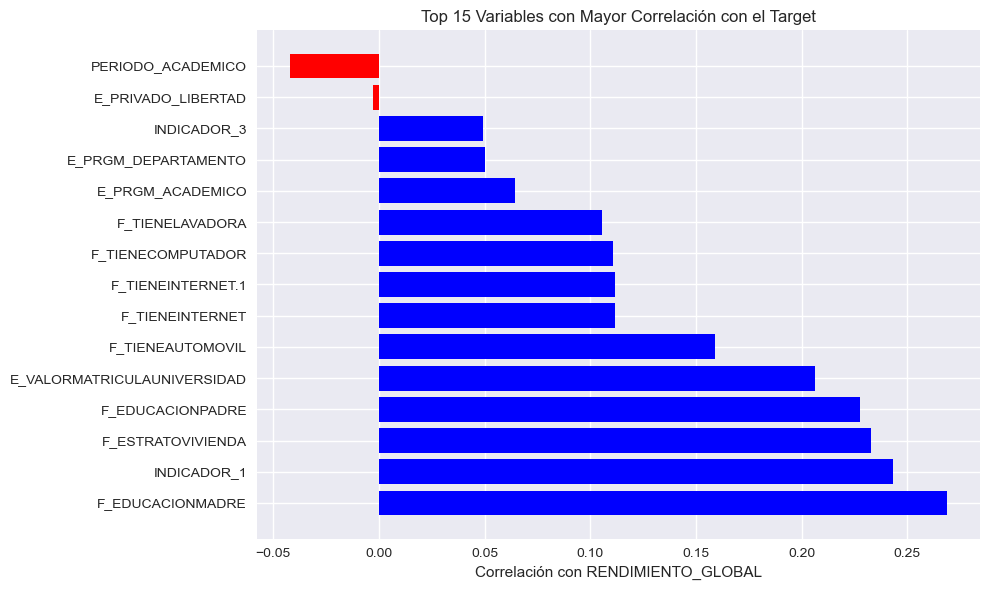


Top 10 variables más correlacionadas con el target:
1. F_EDUCACIONMADRE: 0.269
2. INDICADOR_1: 0.243
3. F_ESTRATOVIVIENDA: 0.233
4. F_EDUCACIONPADRE: 0.228
5. E_VALORMATRICULAUNIVERSIDAD: 0.207
6. F_TIENEAUTOMOVIL: 0.159
7. F_TIENEINTERNET: 0.112
8. F_TIENEINTERNET.1: 0.112
9. F_TIENECOMPUTADOR: 0.111
10. F_TIENELAVADORA: 0.105

=== DATASET PROCESADO ===
Dimensiones finales: (554000, 19)
Memoria aproximada: 84.53 MB

=== RESULTADO FINAL ===
X_train procesado: (554000, 19)
X_test procesado: (138500, 19)
y_train: (554000,)
y_test: (138500,)

Primeras 5 filas de X_train procesado:
        PERIODO_ACADEMICO  E_PRGM_ACADEMICO  E_PRGM_DEPARTAMENTO  \
114179            20195.0           19879.0             225786.0   
309070            20183.0           31597.0              11379.0   
415954            20183.0           13946.0             225786.0   
170334            20195.0          238412.0             225786.0   
64598             20203.0          238412.0             225786.0   

     

In [68]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test, preprocessor = main()